In [1]:
import numpy as np  
import pandas as pd  
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
import os
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import scoped_session, sessionmaker
import xgboost as xgb
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get past 30 days earthquake data from earthquake.usgs.gov that is being updated every minute (live).
Lets import the dataset downloaded from here :- https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv

In [3]:
df=pd.read_csv('all_month2.csv')

# Features in the dataset
* time ---------------------- Time when the event occurred. Times are reported in milliseconds since the epoch
* latitude ------------------- Decimal degrees latitude. Negative values for southern latitudes.
* longitude ------------------ Decimal degrees longitude. Negative values for western longitudes.
* depth ---------------------- Depth of the event in kilometers.
* mag ------------------------ Magnitude of event occured.
* magType -------------------- The method or algorithm used to calculate the preferred magnitude
* nst ------------------------ The total number of seismic stations used to determine earthquake location.
* gap ------------------------ The largest azimuthal gap between azimuthally adjacent stations (in degrees).
* dmin ----------------------- Horizontal distance from the epicenter to the nearest station (in degrees).
* rms ------------------------ The root-mean-square (RMS) travel time residual, in sec, using all weights.
* net ------------------------- The ID of a data source contributor for event occured.
* id -------------------------- A unique identifier for the event.
* types ----------------------- A comma-separated list of product types associated to this event.
* place ----------------------- named geographic region near to the event.
* type ------------------------ Type of seismic event.
* locationSource -------------- The network that originally authored the reported location of this event.
* magSource ------------------- Network that originally authored the reported magnitude for this event.
* horizontalError ------------- Uncertainty of reported location of the event in kilometers.
* depthError ------------------ The depth error, three principal errors on a vertical line.
* magError -------------------- Uncertainty of reported magnitude of the event.
* magNst ---------------------- The total number of seismic stations to calculate the magnitude of earthquake.
* status ---------------------- Indicates whether the event has been reviewed by a human.

In [4]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-12-01T04:00:21.960Z,19.289833,-155.378662,2.47,1.78,md,13.0,176.0,NaN,0.10,...,2023-12-01T04:03:20.620Z,"Hawaii region, Hawaii",earthquake,0.47,0.97,0.88000,3.0,automatic,hv,hv
1,2023-12-01T03:59:38.150Z,33.218500,-115.567000,2.52,1.34,ml,20.0,92.0,0.05777,0.17,...,2023-12-01T04:05:43.061Z,"5 km WSW of Niland, CA",earthquake,0.21,0.31,0.21200,19.0,automatic,ci,ci
2,2023-12-01T03:21:45.610Z,17.931333,-66.275167,13.56,2.63,md,12.0,197.0,0.10450,0.19,...,2023-12-01T03:38:35.900Z,Puerto Rico region,earthquake,0.63,0.50,0.20858,10.0,reviewed,pr,pr
3,2023-12-01T03:14:19.240Z,33.697667,-117.368500,10.87,0.80,ml,35.0,43.0,0.05015,0.22,...,2023-12-01T03:20:38.043Z,"5 km NW of Lake Elsinore, CA",earthquake,0.26,0.54,0.23100,12.0,automatic,ci,ci
4,2023-12-01T03:11:45.133Z,63.261900,-150.362100,65.80,1.90,ml,NaN,NaN,NaN,1.14,...,2023-12-01T03:14:23.112Z,Central Alaska,earthquake,NaN,1.00,NaN,NaN,automatic,ak,ak


In [5]:
df.shape

(9361, 22)

In [6]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,9361.000000,9361.000000,9361.000000,9361.000000,7477.000000,7477.000000,6184.000000,9361.000000,6921.000000,9361.000000,7467.000000,7473.000000
mean,38.435163,-109.857572,22.779658,1.662269,24.042129,109.308869,0.607935,0.280026,1.795419,1.946721,0.225174,16.859896
std,19.228126,70.981082,54.165779,1.260257,22.032916,62.192204,1.997862,0.269817,3.379500,4.278497,0.328544,26.371447
min,-62.281600,-179.959000,-3.390000,-1.320000,3.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.688000,-150.767400,2.940000,0.850000,10.000000,65.000000,0.010950,0.090000,0.260000,0.440000,0.105511,6.000000
50%,38.781000,-122.372167,7.468400,1.460000,18.000000,91.600000,0.053450,0.170000,0.460000,0.730000,0.168000,11.000000
75%,53.855333,-111.898167,15.500000,2.000000,30.000000,138.000000,0.168800,0.440000,1.049286,1.520000,0.232000,18.000000
max,78.740300,179.971000,621.112000,7.100000,260.000000,350.000000,38.326000,3.090000,98.920000,40.350000,5.370000,822.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9361 entries, 0 to 9360
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             9361 non-null   object 
 1   latitude         9361 non-null   float64
 2   longitude        9361 non-null   float64
 3   depth            9361 non-null   float64
 4   mag              9361 non-null   float64
 5   magType          9361 non-null   object 
 6   nst              7477 non-null   float64
 7   gap              7477 non-null   float64
 8   dmin             6184 non-null   float64
 9   rms              9361 non-null   float64
 10  net              9361 non-null   object 
 11  id               9361 non-null   object 
 12  updated          9361 non-null   object 
 13  place            9361 non-null   object 
 14  type             9361 non-null   object 
 15  horizontalError  6921 non-null   float64
 16  depthError       9361 non-null   float64
 17  magError      

We can see lots of null values of certain features, but as part of data wrangling and feature engineering we consider only certain features in final dataframe, hence we choose simply drop or ignore the null values

In [8]:
df.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                1884
gap                1884
dmin               3177
rms                   0
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    2440
depthError            0
magError           1894
magNst             1888
status                0
locationSource        0
magSource             0
dtype: int64

Visualize latitude and longitude feature from 'df' dataframe to see where the points fall from the feature set

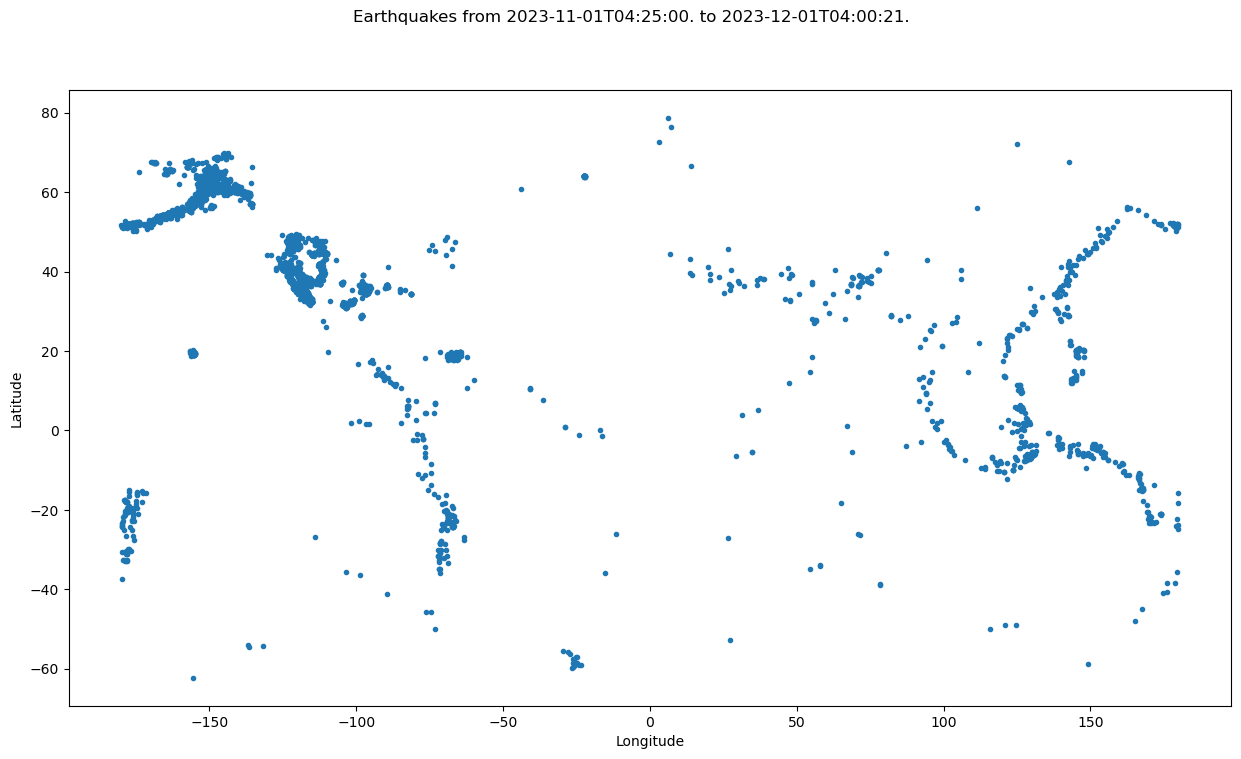

In [9]:
rounding_factor = 10
fig, ax = plt.subplots(figsize=(15,8))

# latitude and longitude of earthquake site of top 10500 samples.
plt.plot(np.round(df['longitude'].head(10500),rounding_factor), 
         np.round(df['latitude'].head(10500),rounding_factor),
         linestyle='none', marker='.')

plt.suptitle('Earthquakes from ' + str(np.min(df['time']))[:20] + ' to ' + str(np.max(df['time']))[:20])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Clean up the data by first extracting only date from 'time' column by considering string[ : 10]. hence we can get desired date

In [10]:
df = df.sort_values('time', ascending=True)

#Date extraction
df['date'] = df['time'].str[0:10]
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,date
9360,2023-11-01T04:25:00.140Z,44.221500,-115.113833,3.890,2.08,ml,11.0,71.0,0.22420,0.22,...,"14 km W of Stanley, Idaho",earthquake,0.51,1.420,0.220719,11.0,reviewed,mb,mb,2023-11-01
9359,2023-11-01T04:26:27.260Z,33.771333,-116.931167,14.970,0.55,ml,16.0,106.0,0.08426,0.10,...,"3 km ESE of San Jacinto, CA",earthquake,0.33,0.450,0.114000,10.0,reviewed,ci,ci,2023-11-01
9358,2023-11-01T04:30:50.570Z,36.020000,-120.583500,4.190,2.42,md,67.0,39.0,0.03945,0.11,...,"19 km NW of Parkfield, CA",earthquake,0.15,0.220,0.103000,77.0,reviewed,nc,nc,2023-11-01
9357,2023-11-01T04:38:06.086Z,61.113000,-150.488400,9.100,1.10,ml,NaN,NaN,NaN,0.53,...,"23 km NNE of Point Possession, Alaska",earthquake,NaN,0.300,NaN,NaN,reviewed,ak,ak,2023-11-01
9356,2023-11-01T04:46:27.591Z,35.079100,67.194600,16.646,4.00,mb,26.0,167.0,1.61300,0.58,...,Central Afghanistan,earthquake,9.29,6.689,0.164000,10.0,reviewed,us,us,2023-11-01


Data cleaning for seperating 'place' column. hence only consider city by seperating string by ', '

In [11]:
# only keep the columns needed
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]
# df['date'] = df['time'].str.split(', ', expand=True) 
newdf = df['place'].str.split(', ', expand=True) 

In [12]:
newdf.head()

,0,1,2
9360,14 km W of Stanley,Idaho,None
9359,3 km ESE of San Jacinto,CA,None
9358,19 km NW of Parkfield,CA,None
9357,23 km NNE of Point Possession,Alaska,None
9356,Central Afghanistan,None,None


In [13]:
df['place'] = newdf[1]
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]

In [14]:
df.head()

,date,latitude,longitude,depth,mag,place
9360,2023-11-01,44.221500,-115.113833,3.890,2.08,Idaho
9359,2023-11-01,33.771333,-116.931167,14.970,0.55,CA
9358,2023-11-01,36.020000,-120.583500,4.190,2.42,CA
9357,2023-11-01,61.113000,-150.488400,9.100,1.10,Alaska
9356,2023-11-01,35.079100,67.194600,16.646,4.00,None


In [15]:
print('total locations:',len(set(df['place'])))

total locations: 94


Bar plot of mean magnitude vs place, as we can see from the graph, only few countries are considered as epicenter or dangerous since they have magnitude more than 2.8 (I have considered here)

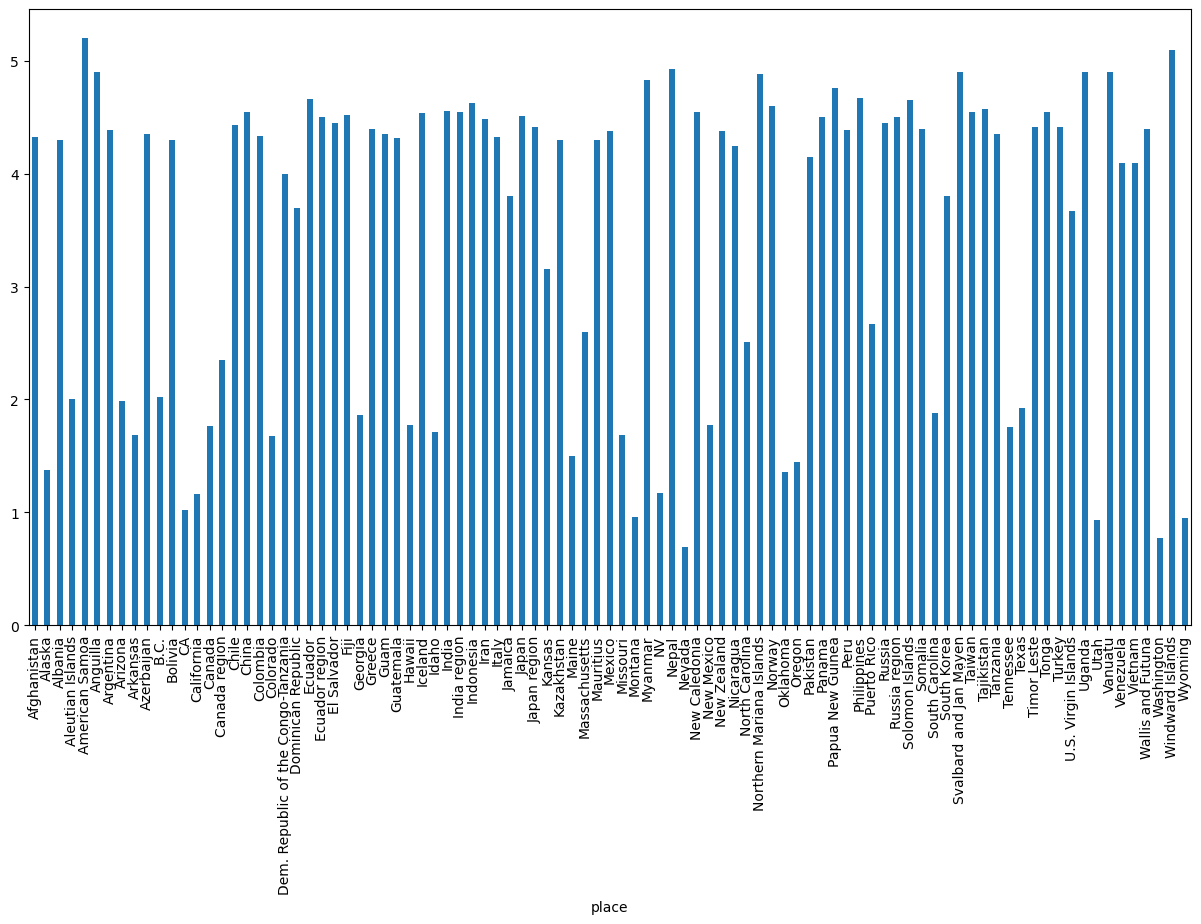

In [16]:
df.groupby(['place'])['mag'].mean().plot(kind='bar',figsize=(15,8));

<Axes: xlabel='place'>

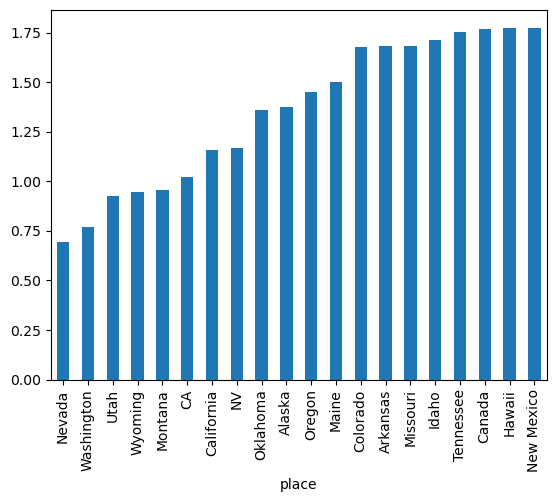

In [17]:
df.groupby(['place'])['mag'].mean().nsmallest(20).plot(kind='bar')

<Axes: xlabel='place'>

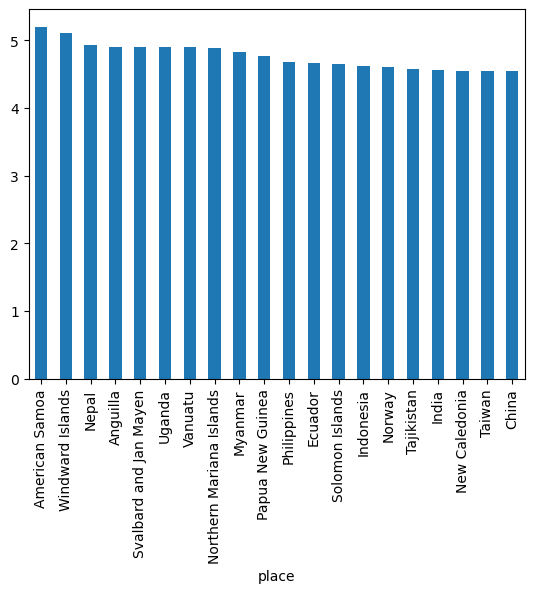

In [18]:
df.groupby(['place'])['mag'].mean().nlargest(20).plot(kind='bar')

In [19]:
more_dangerous_places=df.groupby('place')['mag'].mean()
more_dangerous_places=more_dangerous_places[more_dangerous_places>3]

# Lets consider 3 as threshold for how high the earthquake has hit and lets visualise countries with more than 3 magnitude.

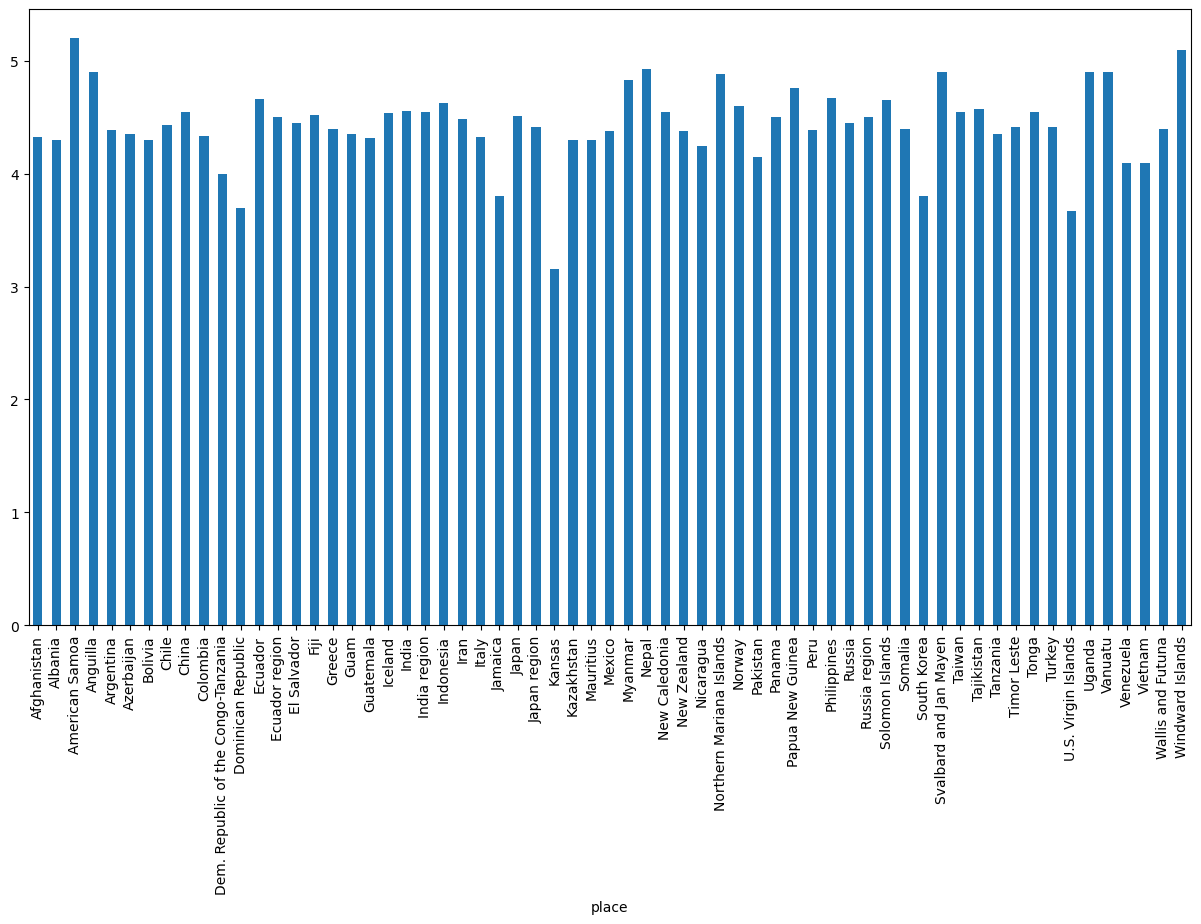

In [20]:
more_dangerous_places.plot(kind='bar',figsize= (15,8));

In [21]:
# calculate mean latitude and longitude for simplified locations

df_coords = df[['place', 'latitude', 'longitude']]
df_coords = df_coords.groupby(['place'], as_index=False).mean()
df_coords = df_coords[['place', 'latitude', 'longitude']]

In [22]:
df_coords.head()

,place,latitude,longitude
0,Afghanistan,36.599355,69.960327
1,Alaska,59.505799,-152.893526
2,Albania,41.087900,19.934300
3,Aleutian Islands,52.215006,-93.752759
4,American Samoa,-15.789300,-171.765200


Merge the two dataframes of mean latitude and longitude locations calculated above with dataframe only considering ['date' , 'depth', 'mag', 'place'] as columns out of total feature

In [23]:
df = df[['date', 'depth', 'mag', 'place']]
df = pd.merge(left=df, right=df_coords, how='inner', on=['place'])
print(df.head())

print('total locations:',len(set(df['place'])))

         date   depth   mag  place   latitude   longitude
0  2023-11-01   3.890  2.08  Idaho  44.394477 -113.632258
1  2023-11-01   6.270  2.06  Idaho  44.394477 -113.632258
2  2023-11-01  10.340  1.14  Idaho  44.394477 -113.632258
3  2023-11-01   4.462  2.40  Idaho  44.394477 -113.632258
4  2023-11-02   8.276  2.20  Idaho  44.394477 -113.632258
total locations: 93


In [24]:
print(set(df['place']))

{'Greece', 'Pakistan', 'Venezuela', 'New Caledonia', 'Wallis and Futuna', 'Russia', 'Washington', 'Chile', 'Nevada', 'Aleutian Islands', 'Oregon', 'Vanuatu', 'Panama', 'China', 'Ecuador', 'Alaska', 'New Mexico', 'Nicaragua', 'Wyoming', 'India region', 'Papua New Guinea', 'Kansas', 'CA', 'Colorado', 'Hawaii', 'Jamaica', 'Tajikistan', 'South Carolina', 'Missouri', 'Somalia', 'Mauritius', 'Italy', 'Bolivia', 'Uganda', 'Canada region', 'South Korea', 'Argentina', 'Dominican Republic', 'Dem. Republic of the Congo-Tanzania', 'Massachusetts', 'Albania', 'Nepal', 'Arkansas', 'Ecuador region', 'Guatemala', 'Iceland', 'Northern Mariana Islands', 'India', 'Philippines', 'Vietnam', 'North Carolina', 'Oklahoma', 'Myanmar', 'Fiji', 'Mexico', 'American Samoa', 'Tonga', 'Japan', 'Kazakhstan', 'Timor Leste', 'Azerbaijan', 'Canada', 'El Salvador', 'Maine', 'Guam', 'U.S. Virgin Islands', 'NV', 'California', 'Taiwan', 'Norway', 'Tennessee', 'Peru', 'Iran', 'Russia region', 'Solomon Islands', 'B.C.', 'Colo

In [25]:
df.head()

,date,depth,mag,place,latitude,longitude
0,2023-11-01,3.890,2.08,Idaho,44.394477,-113.632258
1,2023-11-01,6.270,2.06,Idaho,44.394477,-113.632258
2,2023-11-01,10.340,1.14,Idaho,44.394477,-113.632258
3,2023-11-01,4.462,2.40,Idaho,44.394477,-113.632258
4,2023-11-02,8.276,2.20,Idaho,44.394477,-113.632258


# Feature Engineering and Data wrangling
* Set rolling window size for future prediction based on past values with fixed window size in past
* We have created 6 new features based on rolling window size on average depth and average magnitude.
* A final outcome 'mag_outcome' has been defined as target values and the output is considered as shifted values from set rolling window of past days eg: '7'.

In [26]:
eq_tmp = df.copy()

#rolling window size
DAYS_OUT_TO_PREDICT = 7

# loop through each zone and apply MA
eq_data = []
eq_data_last_days_out = []

for place in list(set(eq_tmp['place'])):
    temp_df = eq_tmp[eq_tmp['place'] == place].copy()
    
    #avg. depth of 22 days rolling period and so on..
    temp_df['depth_avg_22'] = temp_df['depth'].rolling(window=22,center=False).mean() 
    temp_df['depth_avg_15'] = temp_df['depth'].rolling(window=15,center=False).mean()
    temp_df['depth_avg_7'] = temp_df['depth'].rolling(window=7,center=False).mean()
    temp_df['mag_avg_22'] = temp_df['mag'].rolling(window=22,center=False).mean() 
    temp_df['mag_avg_15'] = temp_df['mag'].rolling(window=15,center=False).mean()
    temp_df['mag_avg_7'] = temp_df['mag'].rolling(window=7,center=False).mean()
    temp_df.loc[:, 'mag_outcome'] = temp_df.loc[:, 'mag_avg_7'].shift(DAYS_OUT_TO_PREDICT * -1)
    
    #days to predict value on earth quake data this is not yet seen or witnessed by next 7 days (consider as live next 7 days period)
    
    eq_data_last_days_out.append(temp_df.tail(DAYS_OUT_TO_PREDICT))

    eq_data.append(temp_df)
    

In [27]:
# concat all location-based dataframes into master dataframe
eq_all = pd.concat(eq_data)

In [28]:
eq_all.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
7567,2023-11-03,10.000,4.5,Greece,37.039714,24.526514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7568,2023-11-03,12.906,5.1,Greece,37.039714,24.526514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7569,2023-11-07,22.514,4.5,Greece,37.039714,24.526514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7570,2023-11-11,10.000,4.2,Greece,37.039714,24.526514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7571,2023-11-17,9.996,4.2,Greece,37.039714,24.526514,NaN,NaN,NaN,NaN,NaN,NaN,NaN


location after feature engineering

In [29]:
# remove any NaN fields
eq_all = eq_all[np.isfinite(eq_all['depth_avg_22'])]
eq_all = eq_all[np.isfinite(eq_all['mag_avg_22'])]
eq_all = eq_all[np.isfinite(eq_all['mag_outcome'])]

In [30]:
eq_all.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
5417,2023-11-03,5.33,0.10,Washington,46.824862,-121.945623,6.466364,6.588000,5.657143,0.691818,0.694000,0.417143,0.872857
5418,2023-11-04,4.75,0.83,Washington,46.824862,-121.945623,6.360455,6.940667,4.498571,0.699545,0.654000,0.387143,0.882857
5419,2023-11-04,10.40,1.63,Washington,46.824862,-121.945623,6.766364,7.035333,5.432857,0.745909,0.734000,0.525714,0.840000
5420,2023-11-04,1.99,0.25,Washington,46.824862,-121.945623,6.574091,6.481333,4.660000,0.731818,0.680000,0.517143,0.801429
5421,2023-11-04,1.95,0.95,Washington,46.824862,-121.945623,5.655909,5.232000,4.124286,0.722273,0.679333,0.638571,0.762857


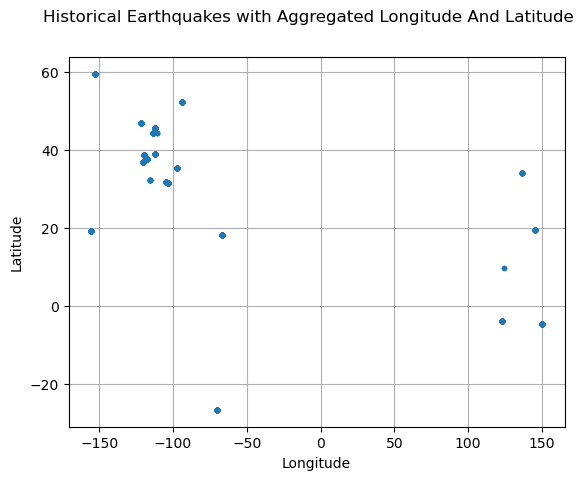

In [31]:
plt.plot(eq_all['longitude'], 
         eq_all['latitude'],
         linestyle='none', marker='.')
plt.suptitle('Historical Earthquakes with Aggregated Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [32]:
# keep our live data for predictions
eq_data_last_days_out = pd.concat(eq_data_last_days_out)


eq_data_last_days_out = eq_data_last_days_out[np.isfinite(eq_data_last_days_out['mag_avg_22'])]
predict_unknown=eq_data_last_days_out

In [33]:
# here 'mag_outcome' has NaN because these are future outcome event to be predicted live or data that has not yet been witnessed
predict_unknown

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
5578,2023-11-30,1.13,0.17,Washington,46.824862,-121.945623,9.915000,10.769333,5.594286,0.795455,0.810000,0.258571,NaN
5579,2023-11-30,4.97,0.90,Washington,46.824862,-121.945623,9.440455,9.982667,4.741429,0.738182,0.770667,0.371429,NaN
5580,2023-11-30,8.11,0.15,Washington,46.824862,-121.945623,9.560455,10.241333,4.788571,0.732273,0.706000,0.412857,NaN
5581,2023-11-30,1.56,0.33,Washington,46.824862,-121.945623,9.211364,9.204000,5.015714,0.730000,0.655333,0.437143,NaN
5582,2023-11-30,0.09,0.39,Washington,46.824862,-121.945623,9.146364,7.145333,3.847143,0.745909,0.568000,0.505714,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6468,2023-11-28,16.97,2.33,Puerto Rico,18.261122,-66.661959,22.937273,21.870000,18.897143,2.678636,2.528000,2.615714,NaN
6469,2023-11-28,15.82,2.97,Puerto Rico,18.261122,-66.661959,21.610909,22.286000,18.720000,2.649091,2.601333,2.758571,NaN
6470,2023-11-29,7.60,2.62,Puerto Rico,18.261122,-66.661959,21.180000,20.888667,17.664286,2.638182,2.571333,2.781429,NaN
6471,2023-11-29,29.19,2.94,Puerto Rico,18.261122,-66.661959,21.721364,17.742667,14.110000,2.664545,2.595333,2.734286,NaN


considered magnitude above 2.5 as dangerous hence prediction outcome as '1' elso '0'.

In [34]:
eq_all['mag_outcome'] = np.where(eq_all['mag_outcome'] > 2.5, 1,0)
print(eq_all['mag_outcome'].describe())
eq_all['mag_outcome'].value_counts()

count    6826.000000
mean        0.043803
std         0.204672
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: mag_outcome, dtype: float64


mag_outcome
0    6527
1     299
Name: count, dtype: int64

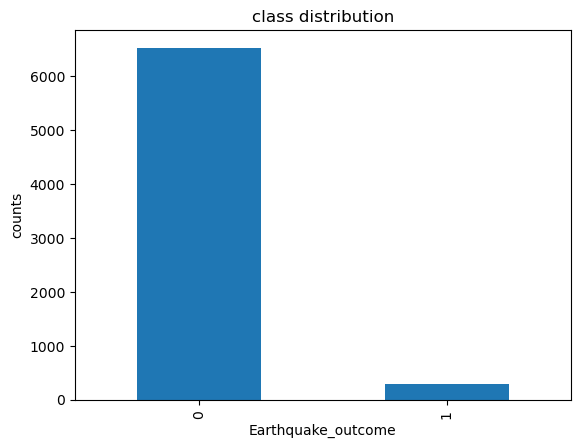

In [35]:
eq_all['mag_outcome'].value_counts().plot(kind='bar',)
plt.xlabel('Earthquake_outcome')
plt.ylabel('counts')
plt.title('class distribution');

# Save the data of of fixed rolling window and live unknown prediction data in sql database using sql engine

In [36]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Earthquakedata.db')
eq_all.to_sql('Earthquake_features', engine, index=False,if_exists='replace')

6826

In [37]:
engine = create_engine('sqlite:///Earthquakedata_predict.db')
predict_unknown.to_sql('Earthquake_predict', engine, index=False,if_exists='replace')

165

Load training and prediction window data from saved sql database

In [38]:
engine =create_engine('sqlite:///Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [39]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2023-11-03,5.33,0.10,Washington,46.824862,-121.945623,6.466364,6.588000,5.657143,0.691818,0.694000,0.417143,0
1,2023-11-04,4.75,0.83,Washington,46.824862,-121.945623,6.360455,6.940667,4.498571,0.699545,0.654000,0.387143,0
2,2023-11-04,10.40,1.63,Washington,46.824862,-121.945623,6.766364,7.035333,5.432857,0.745909,0.734000,0.525714,0
3,2023-11-04,1.99,0.25,Washington,46.824862,-121.945623,6.574091,6.481333,4.660000,0.731818,0.680000,0.517143,0
4,2023-11-04,1.95,0.95,Washington,46.824862,-121.945623,5.655909,5.232000,4.124286,0.722273,0.679333,0.638571,0


In [40]:
engine =create_engine('sqlite:///Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [41]:
# Live data to be predicted on after being trained of rolling period for next 7 days. 
#Hence NaN outcome that has to be predicted

df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2023-11-30,1.13,0.17,Washington,46.824862,-121.945623,9.915000,10.769333,5.594286,0.795455,0.810000,0.258571,NaN
1,2023-11-30,4.97,0.90,Washington,46.824862,-121.945623,9.440455,9.982667,4.741429,0.738182,0.770667,0.371429,NaN
2,2023-11-30,8.11,0.15,Washington,46.824862,-121.945623,9.560455,10.241333,4.788571,0.732273,0.706000,0.412857,NaN
3,2023-11-30,1.56,0.33,Washington,46.824862,-121.945623,9.211364,9.204000,5.015714,0.730000,0.655333,0.437143,NaN
4,2023-11-30,0.09,0.39,Washington,46.824862,-121.945623,9.146364,7.145333,3.847143,0.745909,0.568000,0.505714,NaN


# Training is done by considering 22, 15, 7 days window past features rolling average and outcome data is shifted to next 7 days as prediction.

In [42]:
df_predict.columns

Index(['date', 'depth', 'mag', 'place', 'latitude', 'longitude',
       'depth_avg_22', 'depth_avg_15', 'depth_avg_7', 'mag_avg_22',
       'mag_avg_15', 'mag_avg_7', 'mag_outcome'],
      dtype='object')

In [43]:
df.columns

Index(['date', 'depth', 'mag', 'place', 'latitude', 'longitude'], dtype='object')

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
# Selection of features that are needed for prediction and hence consider only them rest are just ignored for prediction purpose.

features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

# splitting traing and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)

In [46]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

## Training phase
* Models used are :
    * classifier with DecisionTree
    * classifier with RandomForest
    * GridSearch CV as hyper parameter tunning

* Model used for Deployment of application :
    * Xgboost with parameters set from above models

# Decision Tree Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              "base_estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

Parameter tunning with GridSearch CV

In [48]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [49]:
grid_search_ABC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [50]:
pred_ABC=grid_search_ABC.predict(X_test)

# Evaluation Area Under curve & ROC
I have chose ROC_AUC score as evaluation metric since I have to binary classifify wether earthquake happened or not with given features that has been train on past few days window rolling average window.

* With adaboost decision tree classifier and hyper parameter tunning, we get area under curve (score) = 0.8867
* higher the auc score, better is the model since it is better at distinguishing postive and negative classes.
* Make a note here that we get from confusion matrix, False negative = 42 and Recall score =0.7789. We need this value apart from auc score that we will analyze later when we have tested with diffferent models below

0.9452161986319436
AUC: 0.9452


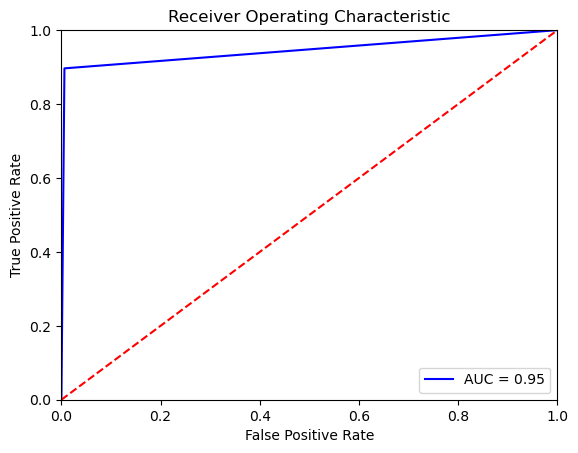

Confusion Matrix: 
 [[1949   12]
 [   9   78]]

Recall 'TP/TP+FN' =  0.896551724137931


In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, pred_ABC))

fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred_ABC))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred_ABC))

# Random Forest Classifier

In [52]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

C:\Users\rupin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rupin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rupin\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\rupin\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\rupin\anaconda3\Lib\site-packages\

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [53]:
pred=CV_rfc.predict(X_test)

# Evaluation Area Under curve & ROC
* Below is the auc score for adaboost RandomForest classifier with 0.916 which is slightly lower than Decision tree classifier
* Moreover when we look at confusion matrix, False Negative=38 and `Recall score = 0.8' can be observed which is slightly higher than recall score of decision tree. Thus performs better than decision tree adabooost

0.9464910583973695
AUC: 0.9465


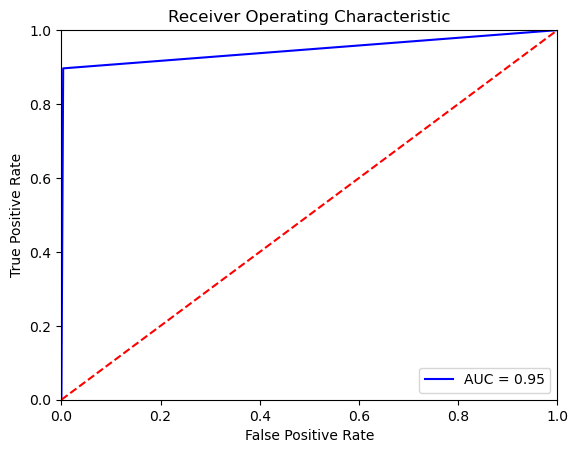

In [63]:
print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



## XGBoost
* We have also tested with xgboost model below with similar parameters as I got above, since grid search CV was taking lot of time for xgboost.
* As we can see this significantly gives higher AUC score of almost 0.0.98 and also False negative = 37 which is similar Random Forest adaboost but xgboost has higher True positive and less False Positve compared to Random forest adaboost. i.e Recall score = 0.805 which is similar adaboost Random Forrest tree. But XGboost is really good at classifying positive and negative classes and also better aur_roc_score = 0.98193.

C:\Users\rupin\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:15:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


0.989660447695581
AUC: 0.9897


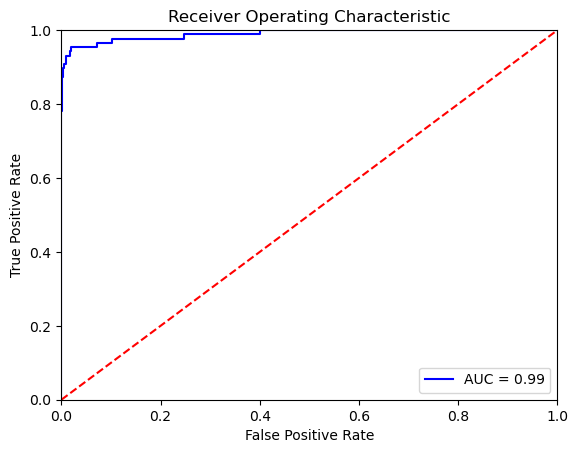

In [62]:
from sklearn.metrics import roc_curve, auc

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.003,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset
num_round = 5000  # the number of training iterations    
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))  

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We can see above that xgboost algorithm has higher auc score (0.9819) than adaboost decision tree and random forest, as it is evident from the ROC curve. Hence we consider xgboost for prediction of live data

# Final thoughts on which model to consider on application:
* Our main Aim is to predict wether earthquake will happen or not at a given day and place. So we definitely would not like the model with higher False Neagtive values , since its more dangerous to predict as no earthquake while in reality earthquake happend than predicting earthquake will happen given in reality it did not. Since its better safe than sorry!!, we can allow False positive more than False negative

* After seeing these comparision on auc_roc score, confusion matrix, and recall score, since all the above algorithm have given similar result with slightly different recall scores, Xgboost with FN=37 but with higher auc_score 0f 0.98 performs over-all better. Hence We have chosen Xgboost as it also faster than adaboost

Preparing prediction and plot for live unknown data we got in df_predict with mag_outcome = Nan

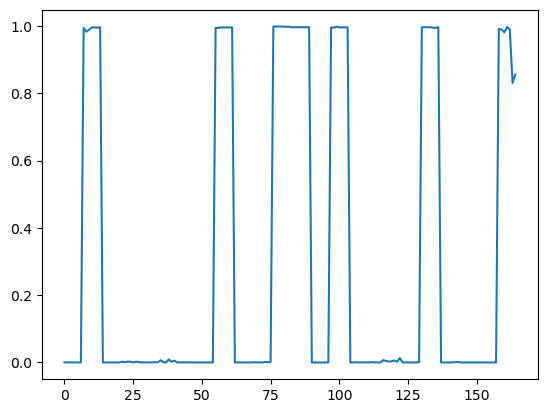

In [56]:
dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(preds)
plt.show()

# Prediction
* Select specific features such as data,place,long,lat and give earthquake probablity from prediction at that place and date as quake probability
* with taking only 7 days rolling period data from predict dataframe since this outcome value is NaN and we need to predict next 7 days period.

In [57]:
#df_p = df[['date', 'place', 'latitude', 'longitude']]
#df=pd.read_csv('all_month.csv')
#df=df[['place', 'latitude', 'longitude','date']]
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

C:\Users\rupin\AppData\Local\Temp\ipykernel_10820\1247293574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  live_set.loc[:,'quake'] = preds


,date,place,latitude,longitude,quake
65,2023-12-08,CA,36.951904,-120.449147,0.000133
66,2023-12-08,Hawaii,19.319540,-155.371779,0.001289
67,2023-12-08,Japan,34.148402,136.625090,0.996497
68,2023-12-08,Nevada,37.826221,-117.357771,0.000102
69,2023-12-08,Texas,31.608845,-103.431082,0.001200


In [58]:
import datetime as dt
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
print(days.sort())

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[2]
predict_day

None


'2023-12-04'

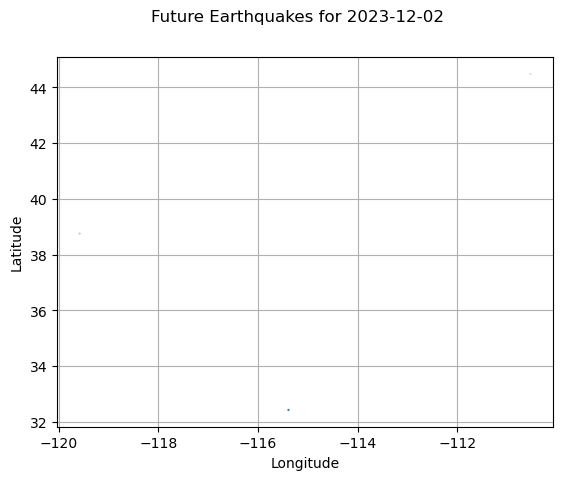

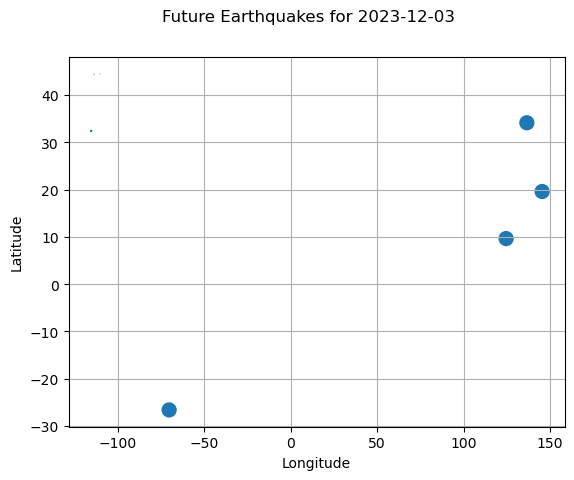

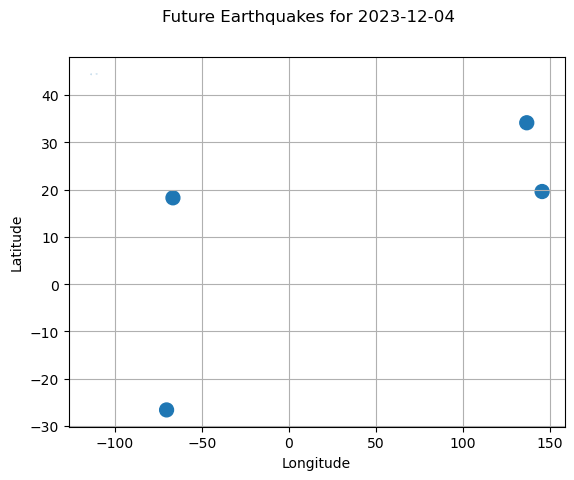

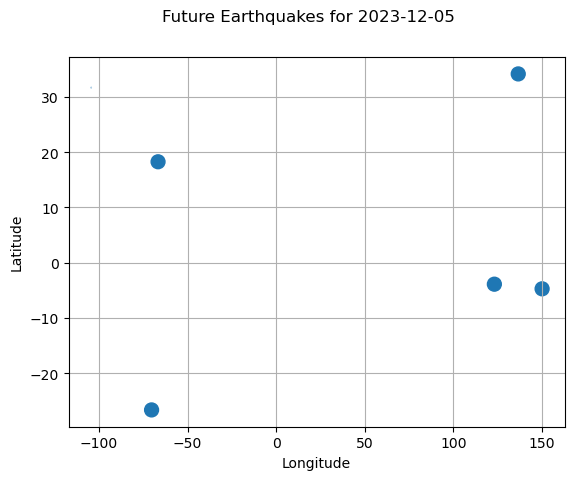

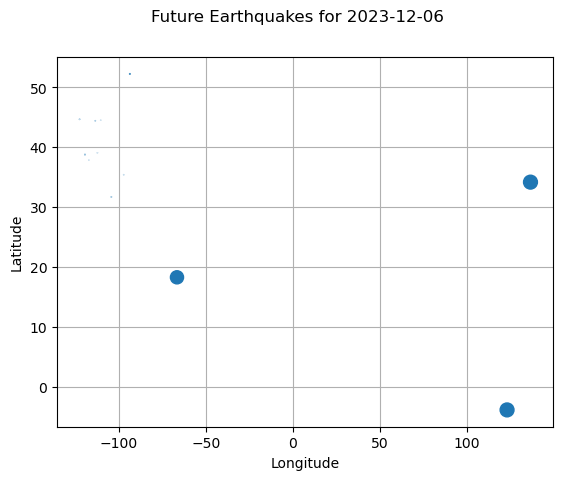

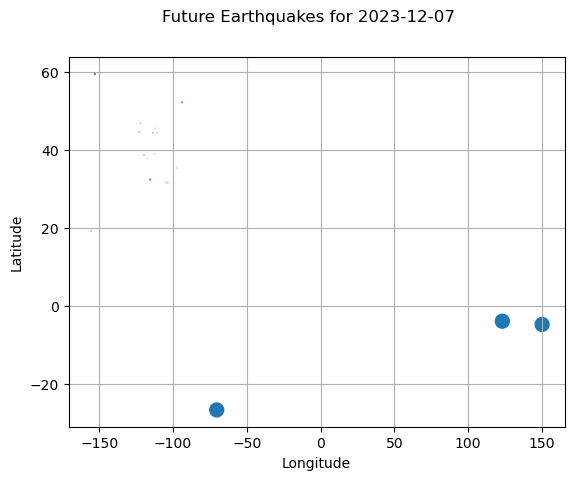

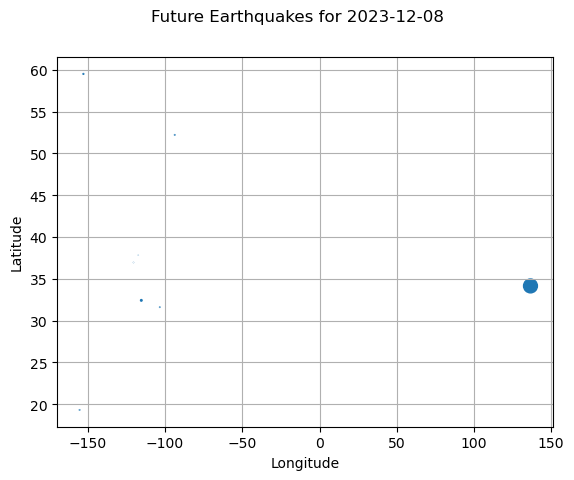

In [59]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()

# Final thoughts:
* So far the model looks good with xgboost as chosen model for predictions  haveing higher auc score and higher recall_score as we have explained under XGBoost result section why auc and recall score are chosen.
* Main Idea of our project will be predicting or forecasting these earthquake sites on given day all over the world.